# **2D Classification pipeline**
___  
  
In this notebook we show how to apply a [BiaPy](https://biapyx.github.io/) pipeline for **2D classification** of [Butterfly](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification) data.

<figure>
<center>
<img src='https://raw.githubusercontent.com/BiaPyX/BiaPy-doc/master/source/img/classification/butterfly_1.jpg' width='100px'/>
<img src='https://raw.githubusercontent.com/BiaPyX/BiaPy-doc/master/source/img/classification/butterfly_2.jpg' width='100px'/>
<img src='https://raw.githubusercontent.com/BiaPyX/BiaPy-doc/master/source/img/classification/butterfly_3.jpg' width='100px'/>
<img src='https://raw.githubusercontent.com/BiaPyX/BiaPy-doc/master/source/img/classification/butterfly_4.jpg' width='100px'/>
<img src='https://raw.githubusercontent.com/BiaPyX/BiaPy-doc/master/source/img/classification/butterfly_5.jpg' width='100px'/>

<figcaption><b>Figure 1</b>: Example of a 2D classification problem. These examples belong to various classes and were sourced from  <a href="https://www.kaggle.com/">  Kaggle</a>, specifically from the Butterfly Image Classification dataset which is a large collection of different butterfly images .</figcaption></center>
</figure>

Without any coding, we'll guide you step-by-step through the process to:
1. **Upload a set of training and test images** along with their corresponding instance label images.
2. **Train a Deep Neural Network (DNN)** model using the training set.
3. **Apply the model** to the test images.
4. **Download the segmentation results** to your local machine.

**Disclaimer:** The structure of the notebook is heavily inspired by the fantastic [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).


**Contact:** This notebook was created by [Ignacio Arganda-Carreras](mailto:ignacio.arganda@ehu.eus), [Lenka Backová](mailto:lenka.backova@ehu.eus) and [Daniel Franco-Barranco](mailto:daniel.franco@dipc.org). For suggestions, comments, or issues, please reach out to us via email or [create an issue in BiaPy's repository](https://github.com/BiaPyX/BiaPy/issues). Thank you!

## **Expected Inputs and Outputs**
___

### **Inputs**

This notebook expects the following folders as input:

1. **Training Raw Images**: Contains the raw 2D images used for training the model.
2. **Test Raw Images**: Houses the raw 2D images for testing the model.
3. **Output Folder**: A designated path where the classification results will be saved.

### **Outputs**

Upon successful execution, a new folder will be generated, housing the classification results. The results will be saved in a CSV file, which can be easily downloaded at the end of this notebook.

<font color='red'><b>Note:</b></font> For testing purposes, you can utilize the **example datasets provided under 'Manage File(s) Source > Option 3'**.

**Data structure**

Input images are expected to be separated into different folders, which correspond to their classification label. Each image label is obtained from the directory name in which that image resides. That is why is so important to follow the directory tree as described below. If you have a .csv file with each image label, as is provided by <a class="reference external" href="https://medmnist.com/">MedMNIST v2</a>, you can use our script <a class="reference external" href="https://github.com/BiaPyX/BiaPy/blob/master/biapy/utils/scripts/from_class_csv_to_folders.py">from_class_csv_to_folders.py</a> to create the directory tree as below:
```
dataset/
├── train
│   ├── 0
│   │   ├── train0_0.png
│   │   ├── train1013_0.png
│   │   ├── . . .
│   │   └── train932_0.png
│   ├── 1
│   │   ├── train104_1.png
│   │   ├── train1049_1.png
│   │   ├── . . .
│   │   └── train964_1.png
| . . .
│   └── 6
│       ├── train1105_6.png
│       ├── train1148_6.png
│       ├── . . .
│       └── train98_6.png
└── test
    ├── 0
    │   ├── test1008_0.png
    │   ├── test1084_0.png
    │   ├── . . .
    │   └── test914_0.png
    ├── 1
    │   ├── test10_1.png
    │   ├── test1034_1.png
    │   ├── . . .
    │   └── test984_1.png
  . . .
    └── 6
        ├── test1021_6.png
        ├── test1069_6.png
        ├── . . .
        └── test806_6.png
```

Here each directory is a number but it can be any string. Notice that they will be considered the class names. Regarding the test, if you have no classes it doesn’t matter if the images are separated in several folders or are all in one folder. But, if `DATA.TEST.LOAD_GT` is enabled, each folder in test path (i.e. ```DATA.TEST.PATH```) will be considered as a class (as done for training and validation).

**Input Format Support**

This notebook is compatible with a range of input formats. You can use the following file extensions: `.tif`, `.png`, `.jpg`, `.npy`, `.h5`, `.hdf5` (every extension supported by [scikit-image](https://scikit-image.org/docs/stable/api/skimage.io.html#skimage.io.imread)).

## **Prepare the environment**
___

Establish connection with Google services. You **must be logged in to Google** to continue.
Since this is not Google's own code, you will probably see a message warning you of the dangers of running unfamiliar code. This is completely normal.


## **Check for GPU Access**
---

By default, the session is configured to use Python 3 with GPU acceleration. However, it's a good practice to double-check these settings:

1. Navigate to **Runtime** in the top menu and select **Change the Runtime type**.
2. Ensure the following settings:
   - **Runtime type:** Python 3 (This program is written in the Python 3 programming language.)
   - **Accelerator:** GPU (Graphics Processing Unit)

This will ensure that you're using Python 3 and taking advantage of GPU acceleration.

## **Install BiaPy**
---
This might take some minutes depending on the current installed libraries in Colab.


In [ ]:
#@markdown ##Play to install BiaPy and its dependences
# Install latest release of BiaPy
!pip install biapy==3.6.5

# Then install Pytorch + CUDA 11.8
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu118

# Finally install some packages that rely on the Pytorch installation
!pip install timm==1.0.14 pytorch-msssim torchmetrics[image]==1.4.*


import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
import ipywidgets as widgets
from ipywidgets import Output
from biapy import BiaPy

changed_source = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.6/434.6 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━

## **Manage File(s) Source**
---

The input folder can be provided using three different options:
1. **Direct Upload**: Directly upload the desired folder.
2. **Google Drive**: Use a folder stored in your Google Drive.
3. **Sample Data**: Use a sample dataset provided by us.

The steps you'll need to follow vary depending on your chosen option. These steps are detailed in the subsequent sections.

### **Option 1: Upload Local Files to the Notebook**
---

To use this option, you will be prompted to upload your files to Colab. The uploaded files will be stored in the `/content/input/` directory. Ensure that you upload a ZIP file that contains the 'train', 'val' (if applicable), and 'test' folders.

In [ ]:
#@markdown ##Play the cell to upload local files (train raw images)
from google.colab import files
!mkdir -p /content/input/train
%cd /content/input/train
uploaded = files.upload()
%cd /content

In [ ]:
# @title  { display-mode: "form" }
# @title  { display-mode: "code" }
#@markdown ##Play the cell to upload local files (test raw images)

from google.colab import files
!mkdir -p /content/input/test
%cd /content/input/test
uploaded = files.upload()
%cd /content

### **Option 2: Mount Your Google Drive**
---

If you wish to use this notebook with data from your Google Drive, you'll first need to mount the drive to this notebook.

Execute the cell below to initiate the Google Drive mounting process. A link will be displayed click on it. In the new browser window that opens, choose your drive and click 'Allow'. Copy the code that appears, return to this notebook, paste the code into the cell, and press 'Enter'. This action grants Colab access to your Google Drive data.

After this process, you can access your data via the **Files** tab, located on the top left of this notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

### **Option 3: Download an Example Dataset**
---
Don't have data readily available but still want to test the notebook? No problem! Simply execute the following cell to download a sample dataset.

Specifically, we'll use the [Butterfly](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification) dataset,which is publicly available online.


In [ ]:
#@markdown ##Play to download an example dataset

import os

!pip install gdown==5.1.0 --quiet
import gdown

os.chdir('/content/')
gdown.download("https://drive.google.com/uc?id=1m4_3UAgUsZ8FDjB4HyfA50Sht7_XkfdB", "data.zip", quiet=True)

!unzip -q data.zip
!rm data.zip

print('Dataset downloaded and unzipped under /content/data')


Dataset downloaded and unzipped under /content/data


## **Paths for Input Images and Output Files**
___

Depending on the option you chose for managing file sources, you'll set your paths differently:

- **Option 1 (Upload from Local Machine)**:
  - Set `train_data_path` to `/content/input/train`
  - Set `test_data_path` to `/content/input/test`
  - Set `output_path` to `/content/out`
  
  
- **Option 2 (Use Google Drive Data)**:
  - Insert the paths to your input files and your desired output directory here, i.e., `/content/gdrive/MyDrive/...`.
  
- **Option 3 (Use Our Sample Data)**:
  - Set `train_data_path` to `/content/data/train`
  - Set `test_data_path` to `/content/data/test`
  - Set `output_path` to `/content/out`
  

  **Note**: Ensure you download your results from the `/content/out` directory after the process!

**Helpful Tip**: If you're unsure about the paths to your folders, look at the top left of this notebook for a small folder icon. Navigate through the directories until you locate your desired folder. Right-click on it and select "Copy Path" to copy the folder's path.

In [ ]:
#@markdown #####Path to train images
train_data_path = '/content/data/train' #@param {type:"string"}
#@markdown #####Path to test images
test_data_path = '/content/data/test' #@param {type:"string"}
#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}

import os
from pathlib import Path

def count_image_files(directory):
    if not directory or not os.path.exists(directory):
        return 0
    image_extensions = {'.jpg', '.jpeg', '.png', '.tif', '.npy', '.tiff', '.h5', '.hd5', '.zarr'}
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if Path(file).suffix.lower() in image_extensions:
                count += 1
    return count

num_train_images = count_image_files(train_data_path)
num_test_images = count_image_files(test_data_path)

print(f"Number of training images: {num_train_images}")
print(f"Number of test images: {num_test_images}")

Number of training images: 2550
Number of test images: 750


## **Dataset Visualization**
---

In [ ]:
# @markdown ## Play to visualize some data samples
# @markdown Select the *Set* (training or test) and the *Class* to visualize samples from, and use the *Instance* scroll to navigate among samples.

# @markdown **Note**: it might take a few seconds to refresh the images.


%matplotlib inline
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import os
from ipywidgets import interact, IntSlider, Layout, Dropdown, HBox, VBox, Output

# Initialize id directories
classes = sorted(next(os.walk(train_data_path))[1])
ids_train = {}
ids_test = {}
for c in classes:
    train_class_path = os.path.join(train_data_path, c)
    test_class_path = os.path.join(test_data_path, c)

    ids_train[c] = [os.path.join(c, f) for f in sorted(next(os.walk(train_class_path))[2])]
    ids_test[c] = [os.path.join(c, f) for f in sorted(next(os.walk(test_class_path))[2])]

# Initialize attributes
class_value = classes[0] # initial class
input_path = train_data_path
ids_input = ids_train

# Initialize widgets

# Dropdown widget to choose training or test set
train_test_dropdown = Dropdown(
    options=['training-set', 'test-set'],
    value='training-set',
    description='Set:',
    disabled=False,
)

# Dropdown widget to choose class
class_dropdown = Dropdown(
    options=classes,
    value=classes[0],
    description='Class:',
    disabled=False,
)

# Slider widget to choose instance
instance_slider= IntSlider(
    value=1,
    min=1,
    max=len(ids_train[class_value]),
    step=1,
    description='Instance:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    layout=Layout(width='500px', margin = '0 0 0 10px')
)

instance_slider.style.description_width = 'initial'
instance_slider.style.handle_color='blue'

# Initialize Output instance to handle code output cell
output = Output()

# Function to update path and image IDs (input_path, ids_input) depending on dropdown
def update_paths(change):
    global ids_input, input_path, classes
    if change.new == 'test-set':
        ids_input = ids_test
        input_path = test_data_path
    else:
        ids_input = ids_train
        input_path = train_data_path

    # Reset class slider value when dropdown changes
    class_dropdown.value = classes[0]
    update_class({'new': classes[0]})

# Function to update class_value attribute depending on the class dropdown
def update_class(change):
    global class_value, ids_input
    class_value = change['new']

    # Reset instance slider value when dropdown changes
    instance_slider.value = 1
    instance_slider.max = len(ids_input[class_value])
    display_images({'new': 1})

# Function to display images depending on instance slider value
def display_images(change):
    with output:
        output.clear_output(wait=True)
        index = change['new']

        global input_path, ids_input, class_value
        input_img = imread(os.path.join(input_path, ids_input[class_value][index-1]))

        # # Print image path to ensure the image displayed is correct
        # print("Image path: ")
        # print(os.path.join(input_path, ids_input[class_value][index-1]))

        # Display images
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title(f"Class: {class_value}, Instance: {index}")
        plt.imshow(input_img)
        # plt.axis('off')

        plt.show()


# Create a VBox to hold the dropdown and slider
controls = VBox([train_test_dropdown, class_dropdown, instance_slider])
display(controls, output)

# Link widgets to functions
train_test_dropdown.observe(update_paths, names='value')
class_dropdown.observe(update_class, names='value')
instance_slider.observe(display_images, names='value')

# Initial display
display_images({'new': instance_slider.value})

Output()

## **Configure and train the DNN model**
---
[BiaPy](https://biapy.readthedocs.io/en/latest/) contains a few deep learning models to perform classification.

The selection of the model and the pipeline hyperparameters can be configured by editing the YAML configuration file or (easier) by running the next cell.



In [ ]:
# @markdown ###OPTIONAL: Check BioImage Model Zoo (BMZ) models compatible with BiaPy
# @markdown Use this option to generate a full list of the available BiaPy-compatible models in the BMZ.

# @markdown **Important:** To select one of the listed models (if any), you will have to run the next cell and select "BioImage Model Zoo" as the source of the model. Then, paste the corresponding model's nickname into the created field.
# @markdown <div><img src="https://bioimage.io/static/img/bioimage-io-logo.svg" width="600"/></div>

import json
from pathlib import Path
import pooch
import yaml
from IPython.display import HTML, display
import logging
from biapy.models import check_bmz_model_compatibility
from packaging.version import Version
from typing import Optional, Dict, Tuple, List, Literal

# Change pooch verbosity
logger = pooch.get_logger()
logger.setLevel("WARNING")

# Extracted from BiaPy-GUI.
# Adapted from BiaPy commit: e5d3bc13fe343160cede4684bdb90bcdf098e4a7 (3.6.1)
def check_model_restrictions(
    model_rdf,
    workflow_specs,
):
    """
    Checks model restrictions to be applied into the current configuration.

    Parameters
    ----------
    model_rdf : dict
        BMZ model RDF that contains all the information of the model.

    workflow_specs : dict
        Specifications of the workflow. If not provided all possible models will be considered.

    Returns
    -------
    option_list: dict
        Variables and values to change in current configuration. These changes
        are imposed by the selected model.
    """
    specific_workflow = workflow_specs["workflow_type"]

    # Version of the model
    model_version = Version(model_rdf["format_version"])
    opts = {}

    # 1) Change PATCH_SIZE with the one stored in the model description. This differs from the code of BiaPy where
    # get_test_inputs() is simply used as there a ModelDescr is build out of the RDF. Here we try to do it manually
    # to avoid fetching files using the network as it may be slow.
    input_image_shape = []
    if "shape" in model_rdf["inputs"][0]:
        input_image_shape = model_rdf["inputs"][0]["shape"]
        # "CebraNET Cellular Membranes in Volume SEM" ('format_version': '0.4.10')
        #   have: {'min': [1, 1, 64, 64, 64], 'step': [0, 0, 16, 16, 16]}
        if isinstance(input_image_shape, dict) and "min" in input_image_shape:
            input_image_shape = input_image_shape["min"]
    else:
        # Check axes and dimension
        input_image_shape = []
        for axis in model_rdf["inputs"][0]["axes"]:
            if 'type' in axis:
                if axis['type'] == "batch":
                    input_image_shape += [1,]
                elif axis['type'] == "channel":
                    input_image_shape += [1,]
                elif 'id' in axis and 'size' in axis:
                    if isinstance(axis['size'], int):
                        input_image_shape += [axis['size'],]
                    elif 'min' in axis['size']:
                        input_image_shape += [axis['size']['min'],]
            elif 'id' in axis:
                if axis['id'] == "channel":
                    input_image_shape += [1,]
                else:
                    if isinstance(axis['size'], int):
                        input_image_shape += [axis['size'],]
                    elif 'min' in axis['size']:
                        input_image_shape += [axis['size']['min'],]
    if len(input_image_shape) == 0:
        raise ValueError("Couldn't load input info from BMZ model's RDF: {}".format(model_rdf["inputs"][0]))
    opts["DATA.PATCH_SIZE"] = tuple(input_image_shape[2:]) + (input_image_shape[1],)

    # Capture model kwargs
    if "kwargs" in model_rdf["weights"]["pytorch_state_dict"]:
        model_kwargs = model_rdf["weights"]["pytorch_state_dict"]["kwargs"]
    elif (
        "architecture" in model_rdf["weights"]["pytorch_state_dict"]
        and "kwargs" in model_rdf["weights"]["pytorch_state_dict"]["architecture"]
    ):
        model_kwargs = model_rdf["weights"]["pytorch_state_dict"]["architecture"]["kwargs"]
    else:
        raise ValueError(f"Couldn't extract kwargs from model description.")

    # 2) Workflow specific restrictions
    # Classes in semantic segmentation
    if specific_workflow in ["SEMANTIC_SEG"]:
        # Check number of classes
        classes = -1
        if "n_classes" in model_kwargs:  # BiaPy
            classes = model_kwargs["n_classes"]
        elif "out_channels" in model_kwargs:
            classes = model_kwargs["out_channels"]
        elif "output_channels" in model_kwargs:
            classes = model_kwargs["output_channels"]
        elif "classes" in model_kwargs:
            classes = model_kwargs["classes"]
        if isinstance(classes, list):
            classes = classes[-1]

        if not isinstance(classes, int):
            raise ValueError(f"Classes not extracted correctly. Obtained {classes}")
        if classes == -1:
            print(model_kwargs)
            raise ValueError("Classes not found for semantic segmentation dir.")

        opts["MODEL.N_CLASSES"] = max(2, classes)
    elif specific_workflow in ["INSTANCE_SEG"]:
        # Assumed it's BC. This needs a more elaborated process. Still deciding this:
        # https://github.com/bioimage-io/spec-bioimage-io/issues/621

        # Defaults
        channels = 2
        channel_code = "BC"

        if "out_channels" in model_kwargs:
            channels = model_kwargs["out_channels"]
        elif "output_channels" in model_kwargs:
            channels = model_kwargs["output_channels"]

        if isinstance(channels, list):
            channels = channels[-1]
        if channels == 1:
            channel_code = "C"
        elif channels == 2:
            channel_code = "BC"
        elif channels == 3:
            channel_code = "BCM"
        elif channels == 8:
            channel_code = "A"

        opts["PROBLEM.INSTANCE_SEG.DATA_CHANNELS"] = channel_code
        opts["PROBLEM.INSTANCE_SEG.DATA_CHANNEL_WEIGHTS"] = [
            1,
        ] * channels
        if channel_code in  ["A", "BC"]:
            opts["LOSS.CLASS_REBALANCE"] = True

    if "preprocessing" not in model_rdf["inputs"][0]:
        return opts

    preproc_info = model_rdf["inputs"][0]["preprocessing"]
    if len(preproc_info) == 0:
        return opts
    preproc_info = preproc_info[0]

    # 3) Change preprocessing to the one stablished by BMZ by translate BMZ keywords into BiaPy's
    # 'zero_mean_unit_variance' and 'fixed_zero_mean_unit_variance' norms of BMZ can be translated to our 'custom' norm
    # providing mean and std
    key_to_find = "id" if model_version > Version("0.5.0") else "name"
    if key_to_find in preproc_info:
        if preproc_info[key_to_find] in ["fixed_zero_mean_unit_variance", "zero_mean_unit_variance"]:
            if (
                "kwargs" in preproc_info
                and "mean" in preproc_info["kwargs"]
            ):
                mean = preproc_info["kwargs"]["mean"]
                std = preproc_info["kwargs"]["std"]
            elif "mean" in preproc_info:
                mean = preproc_info["mean"]
                std = preproc_info["std"]
            else:
                mean, std = -1., -1.

            opts["DATA.NORMALIZATION.TYPE"] = "custom"
            opts["DATA.NORMALIZATION.CUSTOM_MEAN"] = mean
            opts["DATA.NORMALIZATION.CUSTOM_STD"] = std

        # 'scale_linear' norm of BMZ is close to our 'div' norm (TODO: we need to control the "gain" arg)
        elif preproc_info[key_to_find] == "scale_linear":
            opts["DATA.NORMALIZATION.TYPE"] = "div"

        # 'scale_range' norm of BMZ is as our PERC_CLIP + 'scale_range' norm
        elif preproc_info[key_to_find] == "scale_range":
            opts["DATA.NORMALIZATION.TYPE"] = "scale_range"
            if (
                float(preproc_info["kwargs"]["min_percentile"]) != 0
                or float(preproc_info["kwargs"]["max_percentile"]) != 100
            ):
                opts["DATA.NORMALIZATION.PERC_CLIP"] = True
                opts["DATA.NORMALIZATION.PERC_LOWER"] = float(preproc_info["kwargs"]["min_percentile"])
                opts["DATA.NORMALIZATION.PERC_UPPER"] = float(preproc_info["kwargs"]["max_percentile"])

    return opts

# Check the models that BiaPy can consume
COLLECTION_URL = "https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/collection.json"
collection_path = Path(pooch.retrieve(COLLECTION_URL, known_hash=None))
with collection_path.open() as f:
    collection = json.load(f)

model_urls = [entry["rdf_source"] for entry in collection["collection"] if entry["type"] == "model"]

model_rdfs = []
for mu in model_urls:
    with open(Path(pooch.retrieve(mu, known_hash=None)), 'rt', encoding='utf8') as stream:
        try:
            model_rdfs.append(yaml.safe_load(stream))
        except yaml.YAMLError as exc:
            print(exc)

# Check axes, preprocessing functions used and postprocessing.
pytorch_models = []
imposed_vars = []

workflow_specs = {
    "workflow_type": "CLASSIFICATION",
    "ndim": "2D",
    "nclasses": "all",
}
for model_rdf in model_rdfs:
    try:
        (
            preproc_info,
            error,
            error_message
        ) = check_bmz_model_compatibility(model_rdf, workflow_specs=workflow_specs)
    except:
        error = True

    if not error:
        model_imposed_vars = check_model_restrictions(model_rdf, workflow_specs=workflow_specs)
        imposed_vars.append(model_imposed_vars)
        pytorch_models.append(model_rdf)

# Print the possible models
html = "<table style='width:100%''>"
c = 0
for i, model in enumerate(pytorch_models):

    if 'nickname' in model['config']['bioimageio']:
        nickname = model['config']['bioimageio']['nickname']
        nickname_icon = model['config']['bioimageio']['nickname_icon']
    elif 'id' in model['config']['bioimageio']:
        nickname = model['config']['bioimageio']['id']
        nickname_icon = model['config']['bioimageio']['id_emoji']
    else:
        doi = "/".join(model['id'].split("/")[:2])
        nickname = doi
        nickname_icon = doi
    cover_url = "https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/"+nickname+"/"+str(model["version"])+"/files/"+model['covers'][0]
    restrictions = ""
    for key, val in imposed_vars[i].items():
        if key == 'MODEL.N_CLASSES':
            restrictions += "<p>number_of_classes: {}</p>".format(val)
        elif key == "PROBLEM.INSTANCE_SEG.DATA_CHANNELS":
            problem_channels = 'Binary mask + Contours'
            if val == "BC":
                problem_channels = "Binary mask + Contours"
            elif val == 'BP':
                problem_channels = "Binary mask + Central points"
            elif val == 'BD':
                problem_channels = "Binary mask + Distance map"
            elif val == 'BCM':
                problem_channels = "Binary mask + Contours + Foreground mask"
            elif val == 'BCD':
                problem_channels = "Binary mask + Contours + Distance map"
            elif val == 'BCDv2':
                problem_channels = "Binary mask + Contours + Distance map with background"
            elif val == 'Dv2':
                problem_channels = "Distance map with background"
            restrictions += "<p>problem_representation: {}</p>".format(problem_channels)
    if c == 0:
        html += "<tr>"
    html += "<td style='width:33%'>"
    html += "<p style='color:#2196f3'>%s</p><p>Nickname: %s (%s)</p>%s<img src='%s' height='200'></td>"%(
        model['name'],
        nickname,
        nickname_icon,
        restrictions,
        cover_url,
    )
    c +=1
    if c == 3:
        html += "</tr>"
        c=0
html += "</table>"
if len( pytorch_models ) == 0:
    display(HTML('<h1>No BMZ models compatible with BiaPy were found for this task.</h1><br>'))
else:
    display(HTML('<h1>List of models that can be used in BiaPy:</h1><br>'))
    display(HTML(html))


In [ ]:
#@markdown ###Play to select the source to build the model (BiaPy, Torchvision or BioImage Model Zoo) { run: "auto", vertical-output: true, display-mode: "form" }

#@markdown **BiaPy**: to use the models implemented in BiaPy.

#@markdown **Torchvision**: to use models from [Torchvision](https://pytorch.org/vision/stable/index.html).

#@markdown **Bioimage Model Zoo (BMZ)**: to use models from the [BMZ repository](https://bioimage.io/#/). You can run the above cell to generate an updated list of the models that can be used with BiaPy. Copy the nickname from the model and paste it below.
import ipywidgets as widgets
from ipywidgets import Output

changed_source = True
exists_tv = False
exists_bmz = False
# create widgets
source = widgets.ToggleButtons(
    options=['BiaPy', 'Torchvision', 'BioImage Model Zoo'],
    description='Source:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Models created during this workflow', 'Torchvision model', 'BioImage Model Zoo model'],
#     icons=['check'] * 3
)


t_vision = widgets.Dropdown(
    options=['deeplabv3_mobilenet_v3_large', 'deeplabv3_resnet101', 'deeplabv3_resnet50', 'fcn_resnet101', 'fcn_resnet50', 'lraspp_mobilenet_v3_large'],
    value='fcn_resnet50',
    description='Supported:',
    disabled=False,
)

bmz = widgets.Text(
    # value='10.5281/zenodo.5764892',
    placeholder='Nickname of BMZ model',
    description='ID:',
    disabled=False
)

# display the first widget
display(source)

# intialize the output - second widget
out = Output()

def changed(change):
    '''
    Monitor change in the first widget
    '''
    global out
    global exists_bmz
    global exists_tv
    if source.value == 'BiaPy':
        bmz.layout.display = 'none'
        t_vision.layout.display = 'none'
        out.clear_output() #clear output
        out = Output() # redefine output
    else:
        if source.value == 'Torchvision':
          bmz.layout.display = 'none'
          t_vision.layout.display = 'none'
          t_vision.layout.display = 'flex'
          if not exists_tv:
            out.append_display_data(t_vision)
            display(out)
          exists_tv = True
        else:
          t_vision.layout.display = 'none'
          bmz.layout.display = 'none'
          bmz.layout.display = 'flex'
          if not exists_bmz:
            out.append_display_data(bmz)
            display(out)
          exists_bmz = True

# monitor the source widget for changes
source.observe(changed, 'value')

ToggleButtons(description='Source:', options=('BiaPy', 'Torchvision', 'BioImage Model Zoo'), tooltips=('Models…

### **Select your parameters**
---
#### **Name of the model**
* **`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

#### **Data management**

* **`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10**

* **`test_ground_truth`:** Select to use test data folder order as the ground truth class to measure the performance of the model's result. **Default value: True**

#### **Basic training parameters**
* **`number_of_classes`:** Input number of classes present in the problem. It must be equal to the number of subfolders in training and validation (if not extracted from train) folders.

* **`input_channels`:** Input the number of channels of your images (grayscale = 1, RGB = 3). **Default value: 3**

* **`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. For the example dataset, reasonable results can already be observed after 100 epochs. **Default value: 100**

* **`patience`:**  Input how many epochs you want to wait without the model improving its results in the validation set to stop training. **Default value: 20**

#### **Advanced Parameters - experienced users only**
* **`model_architecture`:**  Select the architecture of the DNN used as backbone of the pipeline. Options: ViT, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7 and simple CNN. **Default value: ViT**

* **`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 12**

* **`patch_size`:** Input the size of the patches use to train your model (length in pixels in X and Y). The value should be smaller or equal to the dimensions of the image. **Default value: 100**

* **`optimizer`:** Select the optimizer used to train your model. Options: ADAM, ADAMW, Stochastic Gradient Descent (SGD). ADAM usually converges faster, while ADAMW provides a balance between fast convergence and better handling of weight decay regularization. SGD is known for better generalization.**Default value: ADAMW**

* **`initial_learning_rate`:** Input the initial value to be used as learning rate. If you select ADAM or ADAMW as optimizer, this value should be around 10e-4. **Default value: 0.0001**

 **`learning_rate_scheduler`:** Select to adjust the learning rate between epochs. Options: "None", "Reduce on plateau", "One cycle", "Warm-up cosine decay". **Default value: None**

* **`aggressive_data_augmentation`:** Select to apply more aggressive data augmentation (CutBlur, CutNoise, GridMask, etc.) during training. Otherwise, simple flips and rotations will be applied. **Default value: True**



In [ ]:
###Name of the model:
model_name = "my_2d_classification_butterfly" #@param {type:"string"}

### Data management:
percentage_validation =  10 #@param {type:"number"}
test_ground_truth = True #@param {type:"boolean"}

### Basic training parameters:
number_of_classes = 75#@param {type:"number"}
input_channels = 3 #@param {type:"number"}
number_of_epochs =  100 #@param {type:"number"}
patience =  20 # @param {type:"number"}

### Advanced training parameters:

model_architecture = "ViT" #@param ["ViT", "EfficientNetB0", "EfficientNetB1", "EfficientNetB2", "EfficientNetB3", "EfficientNetB4", "EfficientNetB5", "EfficientNetB6", "EfficientNetB7", "simple_cnn"]

batch_size =  32#@param {type:"number"}
patch_size = 100 #@param {type:"number"}

optimizer = "ADAMW" #@param ["ADAM", "SGD","ADAMW"]
initial_learning_rate = 0.0001 #@param {type:"number"}
learning_rate_scheduler = "None" #@param ["None", "Reduce on plateau","One cycle", "Warm-up cosine decay"]
aggressive_data_augmentation = True #@param {type:"boolean"}

checkpoint_path = ''


In [ ]:
#@markdown ##OPTIONAL: Play the cell to upload initial model weights
#@markdown Use this option to start the training from a **pre-trained model** if you have one. Otherwise, skip this cell.

#@markdown **Important**: remember the weights must correspond to the selected architecture, patch size and number of input channels. Otherwise, an error will be shown when training.
from google.colab import files

#s.chdir('/content/')

uploaded = files.upload()

checkpoint_path = '/content/' + list(uploaded.keys())[0]

# open previously configured file, if exists
job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# edit previous configuration file if it exists to load the checkpoint model
if os.path.exists( yaml_file ):
    import yaml
    with open( yaml_file, 'r') as stream:
        try:
            biapy_config = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

    # save file
    with open( yaml_file, 'w') as outfile:
        yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Pre-trained model loaded and ready to re-train.")

### **Train the model**
---

In [ ]:
#@markdown ##Play to train the model
import os
import errno

os.chdir('/content/')

job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# remove previous configuration file if it exists with the same name
if os.path.exists( yaml_file ):
    os.remove( yaml_file )

# remove template file it is exists
template_file = '2d_classification.yaml'
if os.path.exists( template_file ):
    os.remove( template_file )

# Download template file
!wget https://raw.githubusercontent.com/BiaPyX/BiaPy/master/templates/classification/2d_classification.yaml &> /dev/null

# Check folders before modifying the .yaml file
if not os.path.exists(train_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_path)
ids = sorted(next(os.walk(train_data_path))[1])
if len(ids) == 0:
    raise ValueError("No folders found in dir {}".format(train_data_path))

if not os.path.exists(test_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_data_path)
ids = sorted(next(os.walk(test_data_path))[1])
if len(ids) == 0:
    raise ValueError("No folders found in dir {}".format(test_data_path))


# open template configuration file
import yaml
with open( template_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# update paths to data
#DATA.NORMALIZATION.TYPE
biapy_config['DATA']['TRAIN']['PATH'] = train_data_path
biapy_config['DATA']['TEST']['PATH'] = test_data_path
biapy_config['DATA']['TEST']['LOAD_GT'] = test_ground_truth

# update data patch size
biapy_config['DATA']['PATCH_SIZE'] = '('+str(patch_size)+', '+ str(patch_size)+', ' + str(input_channels)+')'
# adjust test padding accordingly
padding = patch_size // 8
biapy_config['DATA']['TEST']['PADDING'] = '('+str(padding)+', '+ str(padding)+')'

# update training parameters
biapy_config['DATA']['VAL']['FROM_TRAIN'] = True
biapy_config['DATA']['VAL']['SPLIT_TRAIN'] = percentage_validation/100.0
biapy_config['TRAIN']['EPOCHS'] = number_of_epochs
if number_of_epochs < 10:
    biapy_config['LOG'] = {}
    biapy_config['LOG']['CHART_CREATION_FREQ'] = 1
biapy_config['TRAIN']['PATIENCE'] = patience
biapy_config['TRAIN']['BATCH_SIZE'] = batch_size
biapy_config['TRAIN']['OPTIMIZER'] = optimizer
biapy_config['TRAIN']['LR'] = initial_learning_rate

# Data augmentation
if aggressive_data_augmentation == True:
    biapy_config['AUGMENTOR']['DROPOUT'] = True
    biapy_config['AUGMENTOR']['GRIDMASK'] = True
    biapy_config['AUGMENTOR']['CUTBLUR'] = True
    biapy_config['AUGMENTOR']['CUTNOISE'] = True
    biapy_config['AUGMENTOR']['MOTION_BLUR'] = True
    #biapy_config['AUGMENTOR']['ELASTIC'] = True
    #biapy_config['AUGMENTOR']['CUTOUT'] = True
    #biapy_config['AUGMENTOR']['BRIGHTNESS'] = True
    #biapy_config['AUGMENTOR']['CONTRAST'] = True

# learning rate scheduler
if learning_rate_scheduler == 'One cycle':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'onecycle'
elif learning_rate_scheduler == 'Warm-up cosine decay':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'warmupcosine'
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.0
    warmup_epochs = round( number_of_epochs * 0.05 )
    biapy_config['TRAIN']['LR_SCHEDULER']['WARMUP_COSINE_DECAY_EPOCHS'] = warmup_epochs
elif learning_rate_scheduler == 'Reduce on plateau':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'reduceonplateau'
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_FACTOR'] = 0.5
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_PATIENCE'] = 5
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.00001

# change source to build model - biapy, torchvision or bmz
if changed_source:
    if source.value == "BiaPy":
        biapy_config['MODEL']['SOURCE'] = "biapy"
    elif source.value == 'Torchvision':
        biapy_config['MODEL']['SOURCE'] = "torchvision"
        biapy_config['MODEL']['TORCHVISION_MODEL_NAME'] = t_vision.value
    elif source.value == 'BioImage Model Zoo':
        biapy_config['MODEL']['SOURCE'] = "bmz"
        biapy_config['MODEL']['BMZ'] = {}
        biapy_config['MODEL']['BMZ']['SOURCE_MODEL_ID'] = str(bmz.value).strip()
else:
    biapy_config['MODEL']['SOURCE'] = "biapy"


# Transcribe model architecture
# Available models: "ViT", "EfficientNetB0", "EfficientNetB1", "EfficientNetB2",
# "EfficientNetB3", "EfficientNetB4", "EfficientNetB5", "EfficientNetB6",
#  "EfficientNetB7", "simple_cnn"
architecture = "simple_cnn"
if model_architecture == "simple_cnn":
    architecture = 'simple_cnn'
elif model_architecture == "ViT":
    architecture = 'ViT'
elif "EfficientNet" in model_architecture:
    architecture = model_architecture.replace("B", "_b").lower()
biapy_config['MODEL']['N_CLASSES'] = number_of_classes
biapy_config['MODEL']['ARCHITECTURE'] = architecture

# model weights
if checkpoint_path != '':
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True


# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")

# Run the code
biapy = BiaPy(f'/content/{job_name}.yaml', result_dir=output_path, name=job_name, run_id=1, gpu=0)
biapy.run_job()

Training configuration finished.
Date     : 2025-07-14 05:40:50
Arguments: Namespace(config='/content/my_2d_classification_butterfly.yaml', result_dir='/content/output', name='my_2d_classification_butterfly', run_id=1, gpu=0, world_size=1, local_rank=-1, dist_on_itp=False, dist_url='env://', dist_backend='nccl')
Job      : my_2d_classification_butterfly_1
BiaPy    : 3.6.1
Python   : 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch  : 2.4.0+cu118
The following changes were made in order to adapt the input configuration:
Not using distributed mode
[05:40:50.424934] Found 75 test classes
[05:40:50.425356] Configuration details:
[05:40:50.425396] AUGMENTOR:
  AFFINE_MODE: reflect
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: False
  BRIGHTNESS_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3)
  CNOISE_SCALE: (0.05, 0.1)
  CNOIS

100%|██████████| 2295/2295 [00:07<00:00, 324.06it/s]


[05:41:10.847642] Samples of shape (100, 100, 3) will be randomly extracted. Number of samples: 2295
[05:41:10.847869] * Loading validation images . . .


100%|██████████| 255/255 [00:00<00:00, 437.24it/s]


[05:41:11.436977] Samples of shape (100, 100, 3) will be randomly extracted. Number of samples: 255
[05:41:11.437184] ### LOAD RESULTS ###
[05:41:11.437251] *** Loaded train data shape is: (2295, 100, 100, 3)
[05:41:11.437288] *** Loaded validation data shape is: (255, 100, 100, 3)
[05:41:11.437318] ### END LOAD ###
[05:41:11.437368] ###############
[05:41:11.437399] # Build model #
[05:41:11.437427] ###############
[05:41:14.033107] ##############################
[05:41:14.033260] #  PREPARE TRAIN GENERATORS  #
[05:41:14.033286] ##############################
[05:41:14.033392] Initializing train data generator . . .
[05:41:14.036089] Normalization config used for X: {'type': 'zero_mean_unit_variance', 'measure_by': 'image', 'mask_norm': 'as_mask', 'out_dtype': 'float32', 'do_percentile_clipping': False, 'channels_to_analize': None, 'channel_info': None, 'train_normalization': True, 'eps': 1e-06, 'mean': 71.91075414540816, 'std': 64.62318442178312, 'last_X_norm': None, 'last_Y_norm': N

  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|       

[05:41:14.424668] ### END TR-SAMPLES ###
[05:41:14.424775] Train/val generators with 5 workers
[05:41:14.424815] Accumulate grad iterations: 1
[05:41:14.424845] Effective batch size: 32
[05:41:14.424875] Sampler_train = None
[05:41:14.428734] #######################
[05:41:14.428777] # Prepare logging tool #
[05:41:14.428796] #######################
[05:41:14.431052] AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.02
)
[05:41:14.431151] #####################
[05:41:14.431171] #  TRAIN THE MODEL  #
[05:41:14.431188] #####################
[05:41:14.431229] Start training in epoch 1 - Total: 100
[05:41:14.4


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[05:41:16.261075] Epoch: [1]  [ 0/72]  eta: 0:02:11  loss: 4.4145 (4.4145)  Accuracy: 0.0000 (0.0000)  Top 5 accuracy: 0.0625 (0.0625)  lr: 0.000100  iter-time: 1.8276
[05:41:18.387284] Epoch: [1]  [10/72]  eta: 0:00:22  loss: 4.5296 (4.6018)  Accuracy: 0.0312 (0.0369)  Top 5 accuracy: 0.1250 (0.1278)  lr: 0.000100  iter-time: 0.3593
[05:41:20.445458] Epoch: [1]  [20/72]  eta: 0:00:14  loss: 4.3688 (4.4264)  Accuracy: 0.0312 (0.0432)  Top 5 accuracy: 0.1250 (0.1369)  lr: 0.000100  iter-time: 0.2090
[05:41:22.396750] Epoch: [1]  [30/72]  eta: 0:00:10  loss: 4.1984 (4.3327)  Accuracy: 0.0312 (0.0454)  Top 5 accuracy: 0.1250 (0.1462)  lr: 0.000100  iter-time: 0.2003
[05:41:24.346288] Epoch: [1]  [40/72]  eta: 0:00:07  loss: 4.1241 (4.2667)  Accuracy: 0.0312 (0.0389)  Top 5 accuracy: 0.1250 (0.1448)  lr: 0.000100  iter-time: 0.1949
[05:41:26.292657] Epoch: [1]  [50/72]  eta: 0:00:05  loss: 4.0516 (4.2205)  Accuracy: 0.0312 (0.0423)  Top 5 accuracy: 0.1562 (0.1520)  lr: 0.000100  iter-time:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[05:58:05.021591] Releasing memory . . .
[05:58:05.045672] #############
[05:58:05.045719] #  RESULTS  #
[05:58:05.045738] #############
[05:58:05.045755] The values below represent the averages across all test samples
[05:58:05.045780] Epoch number: 45
[05:58:05.045798] Train time (s): 0:16:33
[05:58:05.045850] Train loss: 1.1764784273174074
[05:58:05.045893] Train Accuracy: 0.6555895225869285
[05:58:05.045927] Train Top 5 accuracy: 0.9231770833333334
[05:58:05.045947] Validation loss: 2.1489836424589157
[05:58:05.045970] Validation Accuracy: 0.3959173262119293
[05:58:05.045989] Validation Top 5 accuracy: 0.749243974685669
[05:58:05.046013] Test Accuracy: 0.448
[05:58:05.046031] Confusion matrix: 
[05:58:05.046048] [[8 0 0 ... 0 0 0]
 [0 8 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 6]]
[05:58:05.055655] 
              precision    recall  f1-score   support

  Category 0       0.80      0.80      0.80        10
  Category 1       0.57   

<Figure size 640x480 with 0 Axes>

## **Inspection of the Loss Function and Accuracy**
---

Before proceeding with interpretations, it's pivotal to gauge the training evolution by juxtaposing the training loss against the validation loss. The validation loss casts light on the model's efficacy over a reserved subset of data unseen during training. A deeper understanding can be garnered from [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

- **Training Loss**: This captures the discrepancy between the model's predictions and the actual ground-truth after each epoch.

- **Validation Loss**: This signifies the error between the model's estimates on validation images and their actual counterparts.

As training unfurls, these metrics are expected to wane, eventually plateauing at an optimal, minimal value. Contrasting the trajectories of these losses can yield vital information about the model's adaptability.

- **Decreasing Training and Validation Losses**: This trend is indicative of potential model improvements with further training. Elevating the `number_of_epochs` is advised in such scenarios. Notably, even if the loss curves seem to stabilize towards the tail end, it might be a mere visual effect due to y-axis scaling. The model is considered convergent once the curves genuinely flatten, marking the end of required training.

- **Divergent Losses**: An upward tick in validation loss while training loss gravitates towards zero hints at overfitting. It suggests that the model is intricately memorizing training patterns at the cost of broader applicability. A more substantial training dataset can alleviate this.


The **Accuracy** metric evaluates the model's performance across all classes by contrasting the target class against the predicted output. **A value gravitating towards 1 denotes peak performance.**


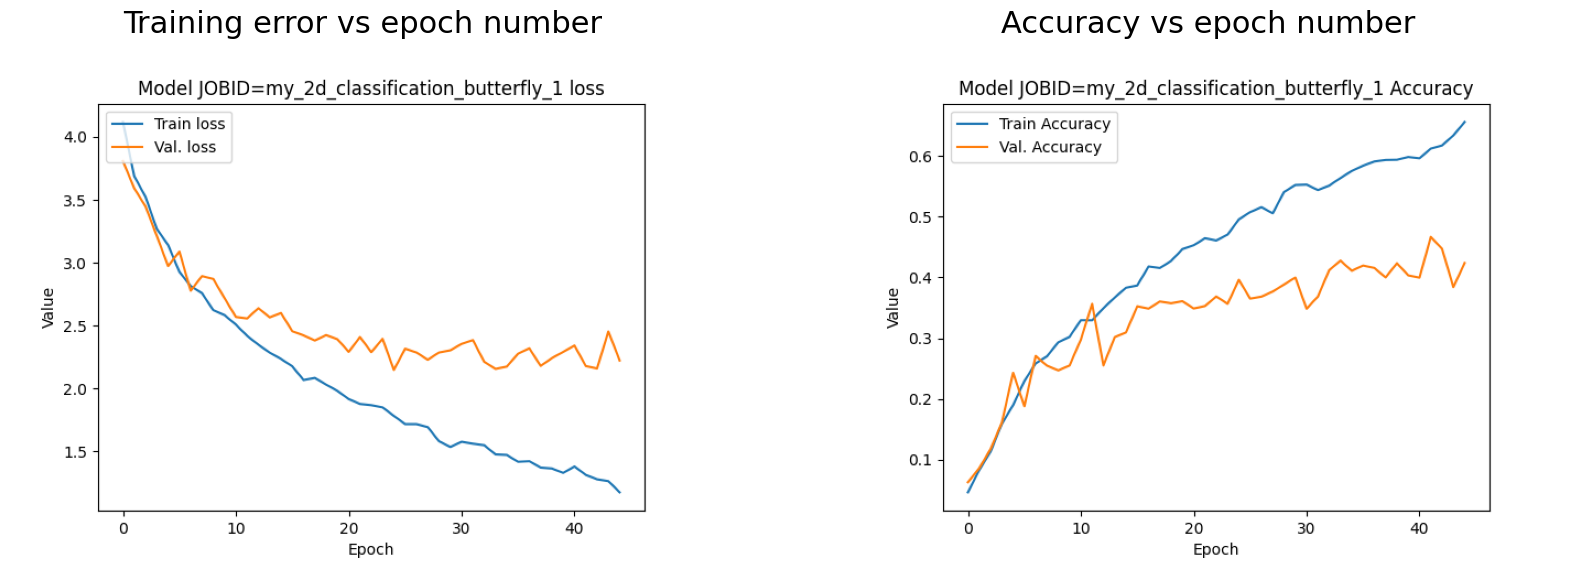

In [ ]:
#@markdown ##Play the cell to show a plot of training error vs. epoch number and accuracy vs epoch number
import matplotlib.pyplot as plt

loss_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_loss.png' )

iou_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_Accuracy.png' )

fig = plt.figure( figsize = (20,10))
ax1 = plt.subplot( 1, 2, 1 )
_ = plt.imshow( loss_plot )
_ = plt.axis('off')
ax1.set_title( 'Training error vs epoch number', fontdict = {'fontsize':22})

ax2 = plt.subplot( 1, 2, 2 )
_ = plt.imshow( iou_plot )
_ = plt.axis('off')
_= ax2.set_title( 'Accuracy vs epoch number', fontdict = {'fontsize':22})

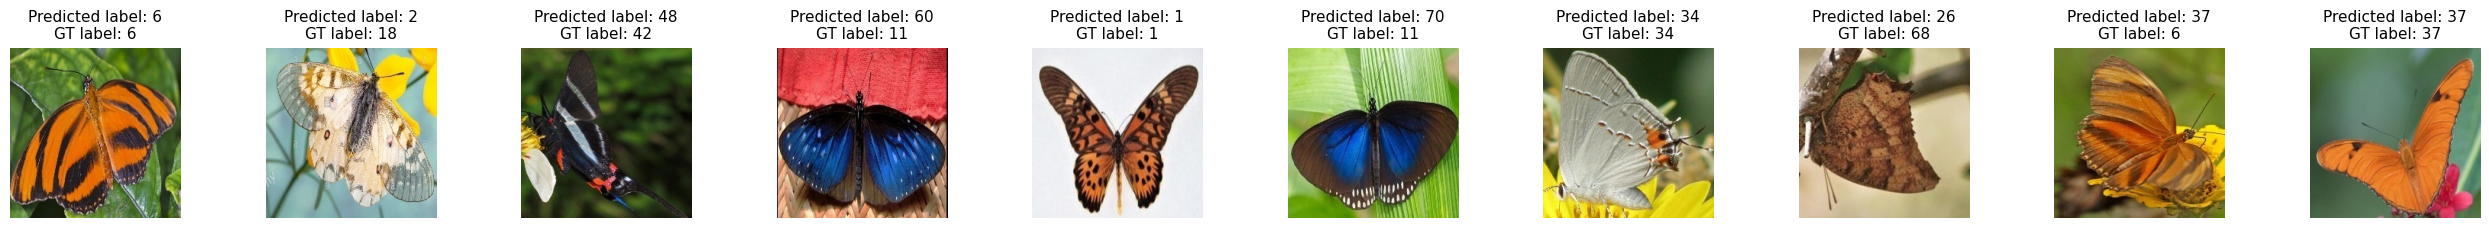

In [ ]:
#@markdown ##Visualize predictions (from the test set)

import pandas as pd
import matplotlib.pyplot as plt
import os

predictions_df = pd.read_csv('/content/output/'+str(job_name)+'/results/'+str(job_name)+'_1/predictions.csv')
#labels = sorted([folder for folder in os.listdir(test_data_path) if os.path.isdir(os.path.join(test_data_path, folder))])

# Reading class names dynamically from folder names
labels = sorted([folder for folder in os.listdir(train_data_path) if os.path.isdir(os.path.join(train_data_path, folder))])

def find_original_class(filename, labels):
    for index, label in enumerate(labels):
        if filename in os.listdir(os.path.join(test_data_path, label)):
            return index
    return None

def display_predictions(predictions_df, labels, num_image):
    random_samples = predictions_df.sample(n=num_image)
    fig = plt.figure(figsize=(25, 25 * num_image))

    for index, (idx, row) in enumerate(random_samples.iterrows()):
        original_class = find_original_class(os.path.basename( row['filename'] ), labels)
        image_path = os.path.join(test_data_path, labels[original_class], row['filename'])
        image = plt.imread(image_path)

        ax = plt.subplot(1, num_image, index + 1)
        if image.shape[-1] == 1 or image.ndim == 2:
            ax.imshow(image, cmap='gray')
        else:
            ax.imshow(image)

        predicted_label_name = row['class']
        original_label_name = original_class

        if test_ground_truth:
            ax.set_title(f"Predicted label: {predicted_label_name}\nGT label: {original_label_name}", fontsize=11)
        else:
            ax.set_title(f"Predicted label: {predicted_label_name}", fontsize=11)

        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

display_predictions(predictions_df, labels, 10)

In [ ]:
#@markdown ###Play to display the path to the output CSV file

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

class_results = os.path.join(final_results, "predictions.csv")

print("Output paths:")
print("    Predicted test classes are in {}".format(class_results))

[05:58:06.026290] Output paths:
[05:58:06.026632]     Predicted test classes are in /content/output/my_2d_classification_butterfly/results/my_2d_classification_butterfly_1/predictions.csv


## **Download classification results**
---

In [ ]:
#@markdown ###Play to download the CSV file with all classification results in test.

from google.colab import files

files.download(class_results)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Download train model (weights and configuration file)**
---
If you want to **reuse the train model in the future**, you can download both the model weights and its configuration file (.YAML) by running the following cells.

In [ ]:
from google.colab import files

#@markdown ###Play to download the model weights

checkpoints_path = os.path.join(output_path, job_name, 'checkpoints')

weights_filename = str( job_name ) + '_1-checkpoint-best.pth'

files.download( os.path.join( checkpoints_path, weights_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ###Play to download the model configuration file (.YAML)

config_path = os.path.join(output_path, job_name, 'config_files')

files.download( os.path.join( config_path, yaml_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Export your model to BioImage Model Zoo format**
---
If you want to export the model into the [BioImage Model Zoo](https://bioimage.io/#/) format, fill the metadata and run the following cell. After the cell is run a `trained_model_name.bmz.zip` file will be downloaded.

In [ ]:

#@markdown ##Construct model's metadata to export it to the BioImage Model Zoo format. Choose just one option:

#@markdown **Option 1: Reuse previous BioImage Model Zoo model configuration**

#@markdown With this option, if you were using a model from BioImage Model Zoo you can select this option to reuse its configuration instead of provide all fields manually. If that's not the case and you try to use this option an error will be thrown.
reuse_previous_BMZ_model_config = False #@param {type:"boolean"}

#@markdown ---

#@markdown **Option 2: Manual export fields**

#@markdown With this option you need to introduce manually the metadata of the model.

#@markdown **Note**: use semicolons to separate different text elements.

# ------------- User input ------------
#@markdown Information about the model:
trained_model_name    = "" #@param {type:"string"}
trained_model_authors =  "First Author Name; Second Author Name; Third Author Name" #@param {type:"string"}
trained_model_authors_github_user =  "First Author GitHub Username; Second Author GitHub Username; Third Author GitHub Username" #@param {type:"string"}
trained_model_description = "" #@param {type:"string"}
trained_model_license = 'CC-BY-4.0'#@param {type:"string"}
trained_model_references = "Ronneberger et al. arXiv in 2015; Franco-Barranco, Daniel, et al. ISBI in 2023" #@param {type:"string"}
trained_model_references_DOI = "10.1007/978-3-319-24574-4_28; 10.1109/ISBI53787.2023.10230593" #@param {type:"string"}
trained_model_tags = "tag-1; tag-2" #@param {type:"string"}
#trained_model_documentation = "/content/README.md" #@param {type:"string"}
#@markdown Information about the dataset used to train the model:
trained_model_dataset_name = "AI Planet, Data Sprint 107: Butterfly Image Classification" #@param {type:"string"}
trained_model_dataset_doi = "10.1109/CVPR.2013.259" #@param {type:"string"}
trained_model_dataset_image_modality = "natural images" #@param {type:"string"}

#@markdown The following field is optional (leave it blank to not use it). It represents the id of the dataset in BMZ page (check [here](https://bioimage.io/#/?type=dataset)). For example, for [MitoEM dataset](https://bioimage.io/#/?type=dataset&id=ilastik%2Fmitoem_segmentation_challenge) the ID is `ilastik/mitoem_segmentation_challenge`.
trained_model_dataset_id = "" #@param {type:"string"}

In [ ]:
#@markdown ###Play to download a zip file with your [BioImage Model Zoo](https://bioimage.io/#/) exported model

#@markdown If everything is correct, you should see some messages containing 🐍 and ✓ symbols.

#@markdown **Note**: after downloading the zip file, remember to open it and check that its ``document.md`` file contains the complete information about the model as you wish to share it.

from google.colab import files
import ast

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")
bmz_results = os.path.join(final_results, "bmz_model")

if not reuse_previous_BMZ_model_config:

    # create the author spec input
    auth_names = trained_model_authors.split(";")
    auth_names = [t.strip() for t in auth_names]

    auth_githubusers = trained_model_authors_github_user.split(";")
    auth_githubusers = [t.strip() for t in auth_githubusers]

    refs = trained_model_references.split(";")
    refs = [t.strip() for t in refs]

    dois = trained_model_references_DOI.split(";")
    dois = [t.strip() for t in dois]


    assert len(auth_names) == len(auth_githubusers)
    authors = [{"name": auth_name, "github_user": auth_guser} for auth_name, auth_guser in zip(auth_names, auth_githubusers)]

    # create the citation input spec
    assert len(refs) == len(dois)
    citations = [{'text': text, 'doi': doi} for text, doi in zip(refs, dois)]

    tags = trained_model_tags.split(",")
    tags = [t.strip() for t in tags]

    with open(trained_model_documentation, "w") as f:
        f.write("### **Description**\n")
        f.write(f"{trained_model_description}\n\n")
        f.write("This model was created using the [BiaPy library](https://biapyx.github.io/).\n")

    bmz_cfg = {}
    # Description of the model
    bmz_cfg['description'] = trained_model_description
    # Authors of the model. Need to be a list of dicts, e.g. authors=[{"name": "Daniel", "github_user": "danifranco"}]
    bmz_cfg['authors'] = authors
    # License of the model. E.g. "CC-BY-4.0"
    bmz_cfg['license'] = trained_model_license
    # List of dictionaries of citations associated, e.g. [{"text": "Gizmo et al.", "doi": "doi:10.1002/xyzacab123"}]
    bmz_cfg['tags'] = tags
    # Tags to make models more findable on the website, e.g. tags=["electron-microscopy", "mitochondria"]
    bmz_cfg['cite'] = citations
    # Path to a file with a documentation of the model in markdown, e.g. "my-model/doc.md"
    #bmz_cfg['doc_path'] = trained_model_documentation
    # Name of the model
    bmz_cfg["model_name"] = trained_model_name
    # Dataset information
    bmz_cfg["data"] = {
        "name": trained_model_dataset_name,
        "doi": trained_model_dataset_doi,
        "image_modality": trained_model_dataset_image_modality,
    }
    if trained_model_dataset_id != "":
        bmz_cfg["data"]["dataset_id"] = trained_model_dataset_id
    biapy.export_model_to_bmz(bmz_results, bmz_cfg)
else:
    try:
        biapy.export_model_to_bmz(bmz_results, reuse_original_bmz_config=True)
    except:
        print("Seems that the was a problem reusing BMZ model specs. Please uncheck 'reuse_previous_BMZ_model_config' and do it manually")

download = True
if not reuse_previous_BMZ_model_config:
    bmz_zip_path = f"/{bmz_results}/{trained_model_name}.zip"
else:
    ids = sorted(next(os.walk(bmz_results))[2])
    ids = [x for x in ids if x.endswith(".zip")]
    if len(ids) > 1:
        print(f"There are more than one ZIP files in {bmz_results} folder. Please check which one you want you want to download and do it manually.")
        download = False
    elif len(ids) == 0:
        print(f"BMZ zip file could not be found.")
        download = False
    else: # only one zip
        ids = ids[0]
    bmz_zip_path = f"/{bmz_results}/{ids}"

if download and os.path.exists(bmz_zip_path):
    files.download(bmz_zip_path)


## **How to use the trained model with new data**
---
To directly infer new data to the trained model, you can use [this notebook](https://github.com/BiaPyX/BiaPy/blob/master/notebooks/BiaPy_Inference.ipynb). It will be necessary to upload the downloaded YAML configuration file and model weights to that notebook.

## **Acknowledgments**
---
We would like to acknowledge the inspiration provided by the excellent [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki). In particular, we have reused some of their descriptions of metrics and parameters.